    mcg   gvh   alm   mit  erl  pox   vac   nuc site
0  0.58  0.61  0.47  0.13  0.5  0.0  0.48  0.22  MIT
1  0.43  0.67  0.48  0.27  0.5  0.0  0.53  0.22  MIT
2  0.64  0.62  0.49  0.15  0.5  0.0  0.53  0.22  MIT
3  0.58  0.44  0.57  0.13  0.5  0.0  0.54  0.22  NUC
4  0.42  0.44  0.48  0.54  0.5  0.0  0.48  0.22  MIT


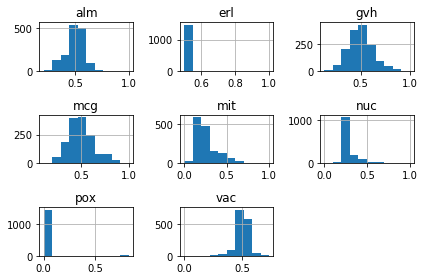

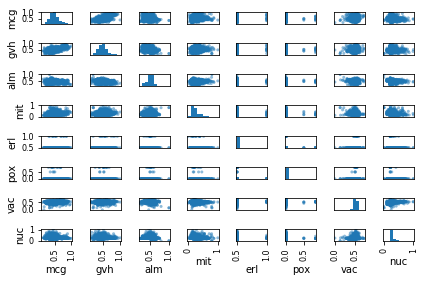

[81, 79, 53, 78, 2, 3, 48, 68, 10]

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
import warnings
import sklearn.metrics as metrics
from sklearn import model_selection
from sklearn.base import clone

df = pd.read_csv("C:/Users/mmcgown/Downloads/Yeast.csv",names = ['sample','mcg', 'gvh', 'alm', 'mit', 'erl', 'pox', 'vac', 'nuc','site'])
df=df.drop(columns=['sample'])
target = 'site'
#Used to take an initial look at the categories of fields
print(df.head())

#Histogram to show overall distribution of each field, count vs values. Tight layout prevents overlap of axis labels.
df.hist()
plt.tight_layout()
plt.show()

#Scatter matrix to show the relation of each field to each other, erl/pox have little interaction since the above distribution is skewed
from pandas.plotting import scatter_matrix
scatter_matrix(df)
plt.tight_layout()
plt.show()

#Below shows the unique values in each column. I have commented it out but I use it to see the unique data in each column.
[df[x].unique().shape[0] for x in df.columns]
#It is [81, 79, 52, 77, 2, 3, 47, 60, 10] which means erl/pox amino acids (columns 5,6) are going to be hard to identify by ML
#The last value is site which we have 10 different site types

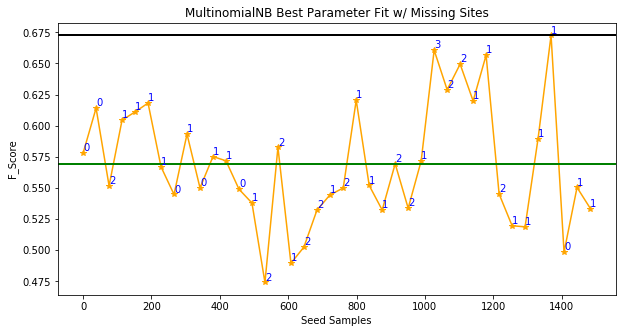

In [5]:
#***************************************************INPUTS***********************************************************************

#These are the three models we'll be testing. To best attempt F_score maxima, models will have no prior fit from previous attempts.
#GaussianNB is false in this way by default.
model_type = [BernoulliNB(fit_prior=False),GaussianNB(),MultinomialNB(fit_prior=False)]
#The model(s) will probably not be able to predict all amino acid sites. What is the max # of sites left unpredicted?
#Constraining to a number lower than 8 will result in more 0 fit scores and lower average fit scores
no_site_tolerance = 3
#Each model converges on a different solution each attempt. How many subdivisions of starting points would you like to try?
seeds = 40
#The model(s) perform differently with different amounts of training. How many equally spaced percentages would you like to send?
train_steps = 10

#*******************************************************************************************************************************

#Makes ndarray of equally spaced train fractions to send to the model.
train_frac = np.linspace(0.1,0.9,train_steps)
#Makes ndarray of equally spaced starting points for the model to find convergence over the sample space.
states = np.linspace(0,df.shape[0],seeds, dtype=int)

#Identify the target field we are aiming to predict. In this case it is the amino acid site.
Y = df[target]
#Prepare to make the fields we aim to train & guess off of with our model as X. Remove the target site column.
df2 = df.drop(columns=[target])
#df2.columns is Index(['mcg', 'gvh', 'alm', 'mit', 'erl', 'pox', 'vac', 'nuc'], dtype='object').
#X is now every except the target site.
X = df[df2.columns[:]] 

#This class assesses the fitness metrics of the trained model
def fit_model(X,Y,states,model,train_size,no_site_tolerance):
    for state in states:
        #X_test, Y_test, clf = train_model(model,train_size)
        clf = clone(model)
        X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, Y, test_size=train_size, random_state=state)
        clf = clf.fit(X_train, Y_train)
        #Ignoring warnings from model because it may not be able to have sufficient data to predict every site
        #The storage and constraining of ill_defined_sites is how we control/interpret what this warn concerns
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            precision = metrics.precision_score(Y_test, clf.predict(X_test), average='weighted')
            recall    = metrics.recall_score(Y_test, clf.predict(X_test), average='weighted')
            f_score = 2/(1/precision+1/recall)
        ill_defined_sites = set(Y_test) - set(clf.predict(X_test))
        if len(ill_defined_sites) <= no_site_tolerance:
            F = f_score
        else:
            F = 0
        results_params[state],results_sites[state] = F, ill_defined_sites
    return results_params, results_sites

#Set parameter names to be part of dictionary
params = ['F','state','train_size']
#Create empty dictionary of these parameter names
param_dict = {param: None for param in params}
#Create empty dictionary to be filled with each model to each parameter dictionary
model_dict = {model_name: param_dict for model_name in model_type}
#Iterate over input model types
for model in model_type:
    #Make empty dictionaries for interim use
    df3_params, df3_sites, results_params,results_sites = {},{},{},{}
    #Iterate over what fraction of data is fed to model
    for train_size in train_frac:
        #Obtain results as dictionary of seed sample states to each resultant F_score from the model
        results_params, results_sites = fit_model(X,Y,states,model,train_size,no_site_tolerance)
        #Put each result in a dictionary for the train size used
        df3_params.update({train_size:pd.Series(results_params)})
        df3_sites.update({train_size:pd.Series(results_sites)})
    #Make empty dictionary to be filled with the best parameters for each model
    best = {}
    #Iterate over the train sizes to store the best F_score and its best parameters
    for key in df3_params.keys():
        #If this F_score is the first one or greater than the last one
        if not best or best['F'] < df3_params[key].max():
            #Store this in the best dictionary
            best = {'train_size':key,'state':df3_params[key].idxmax(),'F':df3_params[key].max()}
    #If the highest F_score for that model was not 0
    if best['F']:
        #Store the best settings and F_score for each model
        model_dict.update({model:best})
    else:
        #Drop that model from the dictionary if it has no F_score
        model_dict.pop(model)
#Make empty dictionary to store the best model and its settings in
results_params, results_sites, best_model = {}, {}, {}
for model in model_dict.keys():
    if not best_model or best_model['F'] < model_dict[model]['F']:
        model_train_size, model_state, model_F = model_dict[model]['train_size'],model_dict[model]['state'],model_dict[model]['F']
        best_sites = df3_sites[model_train_size][model_state]
        best_model = {'model':model,'state':model_state,'train_size':model_train_size,'F':model_F,'sites':best_sites}
results_params,results_sites = fit_model(X,Y,states,best_model['model'],best_model['train_size'],no_site_tolerance)

#Find out how much the avg_F of a model run with optimal parameters differs from the best F obtained from all models/train sizes/seeds
#Note that lower inputs of no_site_tolerance get more 0 F_scores, increasing the delta between avg_F and best_model F.
total = 0
for key in results_params.keys():
    total += results_params[key]
avg_F = total/len(results_params.keys())

import re
title = re.search('[^(]*',str(best_model['model']))
plt.figure(figsize=(10,5))
plt.plot(results_params.keys(), results_params.values(), color='orange',marker='*')
for key,value in zip(results_params.keys(),results_params.values()):
    plt.annotate(xy=(key,value),s=len(results_sites[key]),xytext=(key*1.00,value*1.00),ha='left',va='bottom',color='blue')
plt.axhline(y=avg_F,linewidth=2, color='g')
plt.axhline(y=best_model['F'],linewidth=2, color='black')
plt.title(title.group(0)+' Best Parameter Fit w/ Missing Sites')
plt.xlabel('Seed Samples')
plt.ylabel('F_Score');